## <u>HW4 – statistics and data analysis</u>
### Differential Gene Expression in Acute Myocardial Infraction

### IDs:
Insert yours IDs to the cell below

ID #1: 203909320

ID #2: 311132468


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import special
from  statistics import median
from scipy.optimize import minimize
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import random
import time
from scipy.stats import norm
pd.reset_option('^display.', silent=True)

### <u>Arranging and preparing the dataset</u>

In [2]:
df = pd.DataFrame(pd.read_csv("AMI_GSE66360_series_matrix.csv", encoding= 'unicode_escape',header=None)).copy()
df = df.drop(np.arange(59))
df = df.reset_index(drop=True)
df.columns = df.iloc[1].copy()
df = df.drop([1]).reset_index(drop=True);
df.columns = pd.MultiIndex.from_tuples(list(zip(df.columns,df.loc[0].copy())))
df = df.drop([0]).reset_index(drop=True);
cols = df.columns
df[cols[1:]] = df[cols[1:]].apply(pd.to_numeric, errors='coerce')
df = df.sort_index(axis=1,level = 1)
df.head()

,ID_REF,GSM1620819,GSM1620820,GSM1620821,GSM1620822,GSM1620823,GSM1620824,GSM1620825,GSM1620826,GSM1620827,...,GSM1620908,GSM1620909,GSM1620910,GSM1620911,GSM1620912,GSM1620913,GSM1620914,GSM1620915,GSM1620916,GSM1620917
,Class,H,H,H,H,H,H,H,H,H,...,M,M,M,M,M,M,M,M,M,M
0,1007_s_at,5.866378,4.948736,5.148384,5.064419,5.017833,5.116154,5.431328,5.235271,5.773528,...,5.419482,5.057716,5.996493,5.343133,5.558892,6.472517,5.678816,5.653286,6.013841,5.465334
1,1053_at,8.225790,7.525865,7.764637,7.198461,7.831450,7.203592,7.694551,7.760259,8.279814,...,7.226348,7.105538,5.354105,8.271500,5.963346,8.261422,6.925753,7.918424,7.442701,9.225221
2,117_at,6.179732,6.628137,5.859151,5.974135,6.793079,6.435229,6.320546,6.483590,6.387779,...,6.789501,7.441940,7.026929,6.003973,7.474326,6.367759,6.835756,7.577035,7.147417,6.481128
3,121_at,6.179478,6.582889,6.602135,6.545905,5.911542,6.285420,6.562316,6.345888,6.272806,...,6.513437,6.317523,7.413453,6.809103,5.949091,6.440978,6.955883,6.499215,6.587065,6.897591
4,1255_g_at,2.792048,2.695714,2.580181,2.712124,2.723687,2.706684,2.674747,2.635150,2.696649,...,2.924658,2.714103,3.635945,2.710944,2.979381,3.730139,2.914868,3.013901,2.729320,3.151449


### a. <u>High level description of the data and some pre-processing</u>

#### 1) How many genes profiled?

In [46]:
df.shape[0]

54628

#### 2) How many samples (subjects/patients) in total?

In [4]:
df.shape[1] - 1 

99

#### 3) How many samples in each class?

In [5]:
h_m = df.loc[0].groupby(level=1).count().reset_index()
h_m.columns = ['class','count']
h_m = h_m.drop([0]).reset_index(drop=True);
h_m

,class,count
0,H,50
1,M,49


#### 4) If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [6]:
print("Before removal: 54675 genes")
df = df.dropna().reset_index(drop=True)
print("After removal: {0} genes".format(df.shape[0]))
dfc = df.copy()

Before removal: 54675 genes
After removal: 54628 genes


#### 5) Pick 20 genes at random. Draw histograms comparing expression levels of each of these genes in the two classes M and H.

In [7]:
samp = df.sample(n = 20)
samp

,ID_REF,GSM1620819,GSM1620820,GSM1620821,GSM1620822,GSM1620823,GSM1620824,GSM1620825,GSM1620826,GSM1620827,...,GSM1620908,GSM1620909,GSM1620910,GSM1620911,GSM1620912,GSM1620913,GSM1620914,GSM1620915,GSM1620916,GSM1620917
,Class,H,H,H,H,H,H,H,H,H,...,M,M,M,M,M,M,M,M,M,M
18458,209073_s_at,7.866830,8.104097,7.772531,7.701864,7.747423,7.806101,7.789451,7.523551,7.894244,...,7.925344,8.457384,6.387343,7.916739,6.333844,5.071003,9.287473,8.221872,8.392758,7.976889
32178,222945_x_at,3.820688,4.594286,5.191707,3.866246,3.801758,3.740075,3.839238,3.864401,3.890634,...,3.880196,3.950196,4.999758,5.278609,6.622553,4.817871,5.205603,3.977701,3.693567,4.352376
41074,231867_at,4.994593,7.076854,3.975526,4.263298,6.261636,4.928299,5.772139,6.010972,3.361228,...,3.847724,7.128350,8.807396,5.858559,5.801417,6.830245,7.453080,4.354242,4.169199,5.824683
17316,207907_at,7.230519,7.029718,6.650810,7.425022,6.849139,7.291669,6.724148,7.047236,6.898660,...,5.419309,5.467020,7.236318,5.598884,6.806714,7.316563,6.587764,6.305483,6.073351,7.717880
41113,231906_at,3.079128,5.009288,3.310132,5.360892,3.905827,3.039996,4.494478,5.329093,2.940404,...,3.973017,5.402223,7.320181,7.486017,5.264052,5.349738,4.704819,4.752152,3.681998,5.221060
5807,1561192_at,3.091340,2.953856,3.484492,3.402591,3.867833,3.266024,3.075375,3.589440,4.750010,...,4.592662,5.460491,3.237471,5.184506,7.255009,4.831480,4.373009,3.531166,5.521883,7.521784
31761,222528_s_at,8.457392,9.089852,7.603833,7.198780,8.067468,7.884022,9.069623,8.072823,8.851890,...,8.632181,9.159121,10.808227,9.339394,6.878483,7.164843,10.330330,9.136273,9.822355,6.868765
51982,242780_at,6.142841,5.771020,6.410777,6.507379,7.326506,6.255927,6.091984,6.676396,6.809175,...,6.143409,6.752853,5.847608,6.861373,5.303266,6.477816,6.566224,5.642701,6.951569,6.298593
11206,201777_s_at,9.580098,9.532630,9.998946,9.754592,9.549745,9.985321,9.572504,10.863274,9.194783,...,9.276671,9.282427,7.422044,8.105206,7.777648,4.760214,7.850954,8.491563,8.435503,7.980186


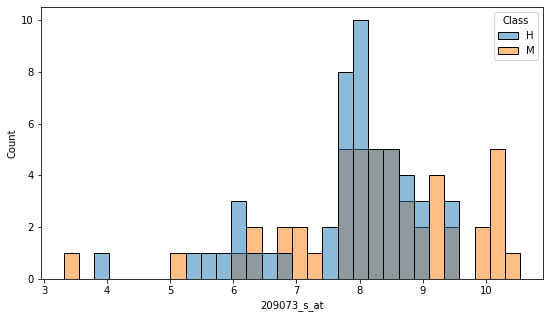

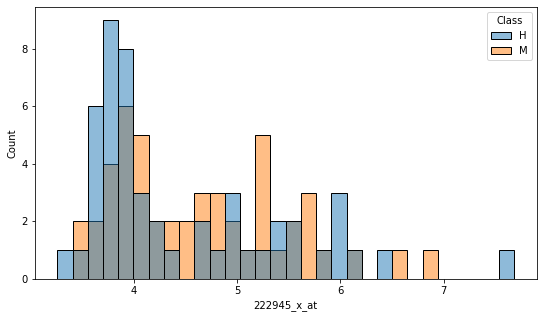

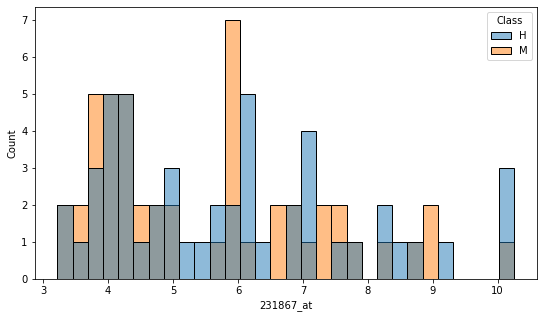

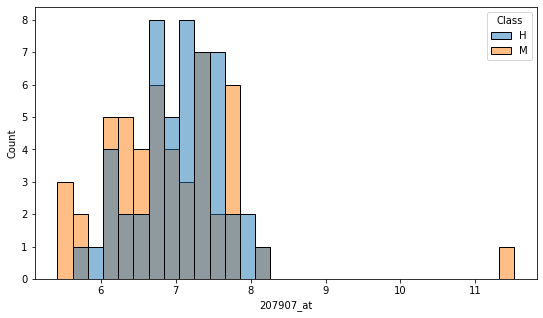

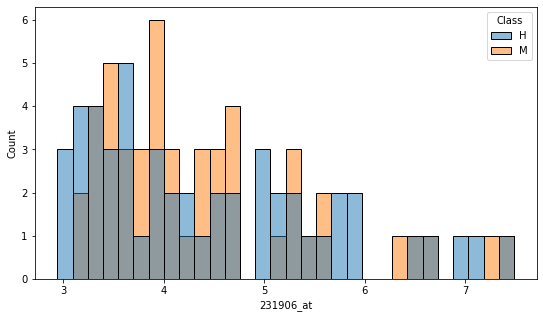

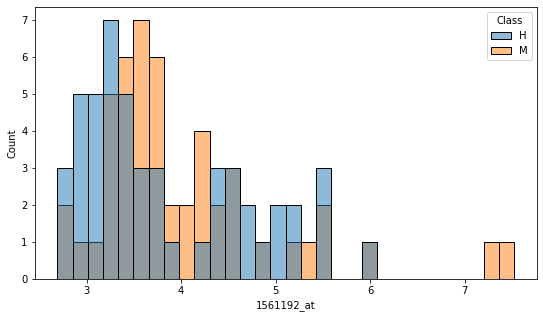

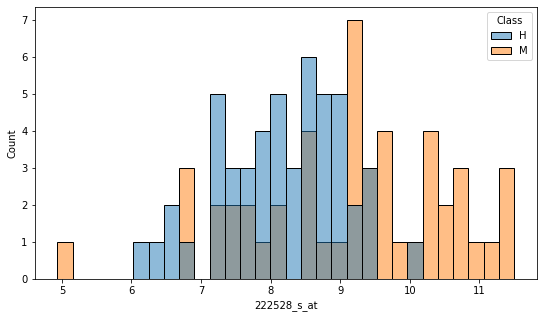

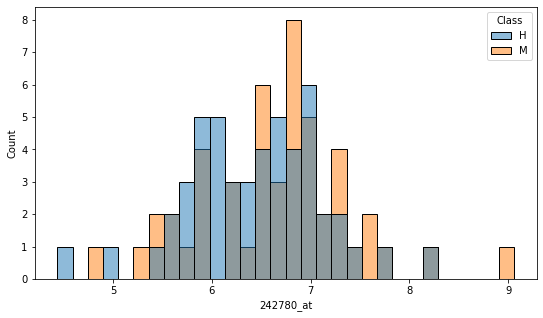

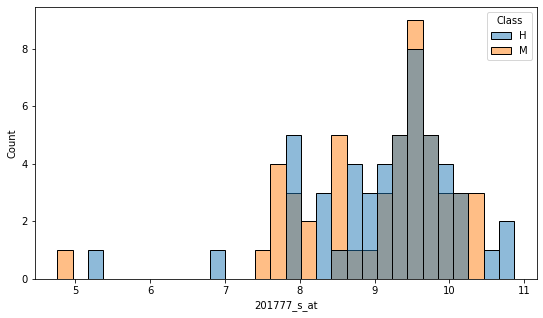

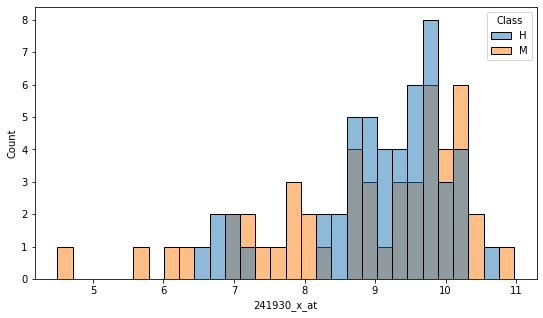

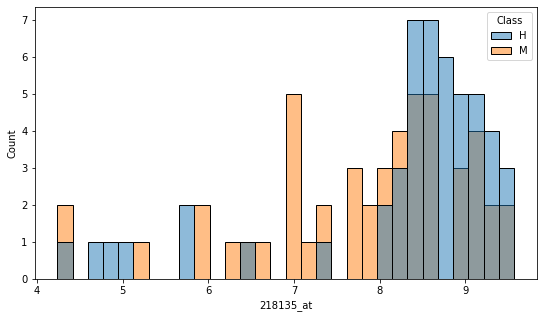

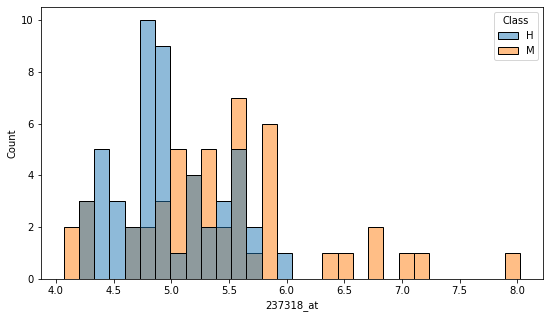

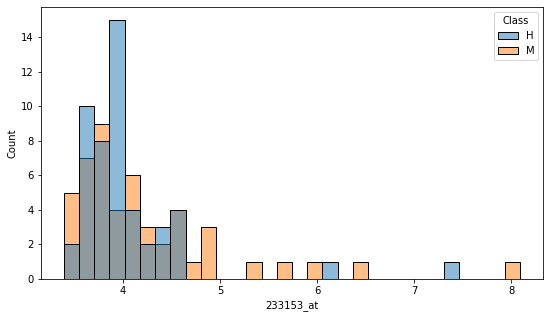

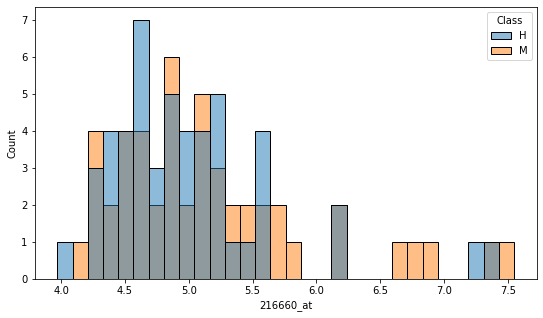

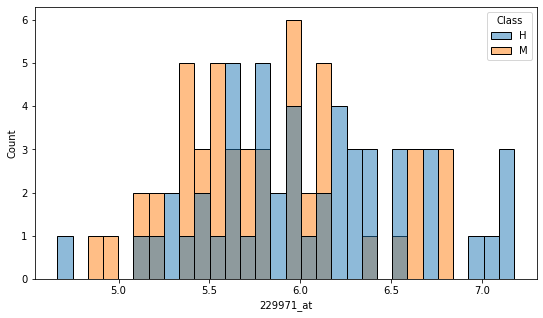

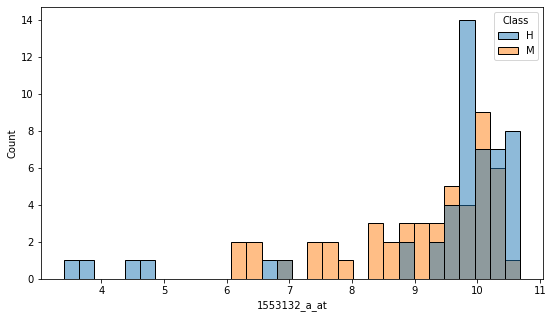

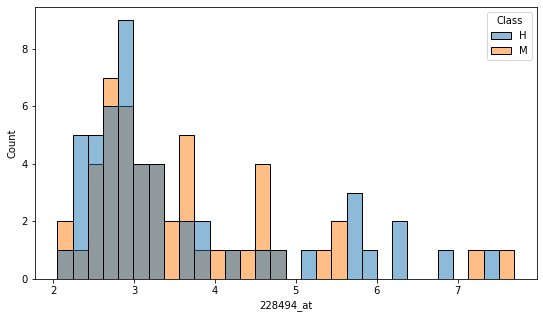

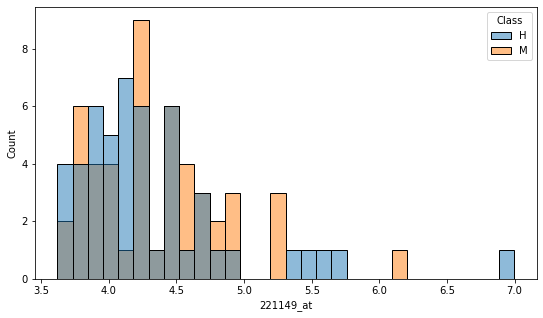

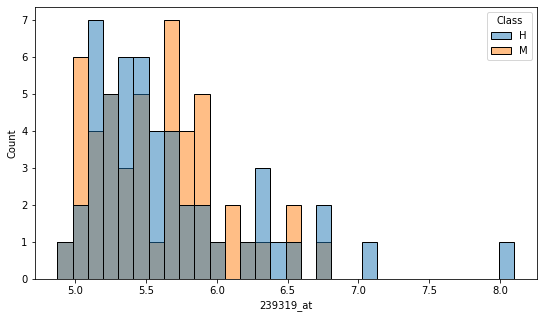

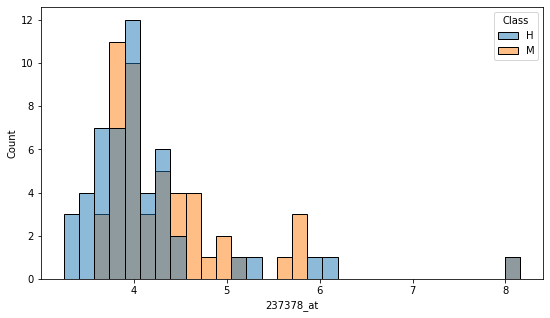

In [8]:
for i in range(20):
    row = samp.iloc[i].reset_index().copy()
    gene_name = row.reset_index().iloc[0,3]
    row = row.drop([0]).reset_index(drop=True)
    row.columns = ["Genes","Class",gene_name]
    plt.figure(figsize=(9,5))
    sns.histplot(data=row, x=gene_name, hue="Class",bins = 30)
    

### b. <u>WRS for differential expression </u>

#### 1) Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of                  ranks of g’s expression levels measured for samples labeled M?

$$E[RS(g)]=\mu_M = \frac{B\cdot (N+1)}{2}= \frac{49\cdot (99+1)}{2} = 2450$$

#### 2) Denote  this  sum  of  ranks  by  RS(g). What  is  the maximal value, c, that RS(g) can take?

$$ RS(g) = \sum_{i=51}^{99}i = 3675 $$

#### 3) Under  the  null  model,  what  is  the  probability  of  RS(g)  = c? (provide a formula for this and explain it)

under the null model there is no M vs H DE. thus Under the null model - all configurations are equiprobable with a similiar probability. we are looking at sum of ranks of g’s expression levels measured for samples labeled M  and we've shown already that M contains 49 samples, and overall 99 samples, so there are 49 ranks to be chosen out of 99 samples.
in hebrew its as follows:
$$ P[RS(g) = c] = \frac{1}{{99 \choose 49}} $$ 

#### 4.1) Under the null model, what is the probability of RS(g) = c-1? 

$P[RS(g) = c-1]$ under the null model doesnt differ from $P[RS(g) = c]$ Due to the fact that there are still 49 ranks to be chosen out of 99 samples in the same possible number of permutations. the single change that comes to action is replacing the $51^{th}$ rank with the $50^{th}$ rank, and that change is produced under the same probability:
$$ P[RS(g) = c-1] = \frac{1}{{99 \choose 49}} $$ 

#### 4) Under the null model, what is the probability of RS(g) = c-2? 

$P[RS(g) = c-2]$ under the null model **does** differ from $P[RS(g) = c]$ and $P[RS(g) = c-1]$ Due to the fact that there are 2 possible changes. the first is replacing the $51^{th}$ rank with the $49^{th}$ rank and the second is $52^{th}$ rank with the $50^{th}$ rank.
this will yield the following probability:
$$ P[RS(g) = c-2] = \frac{1}{{99 \choose 49}} + \frac{1}{{99 \choose 49}} = \frac{2}{{99 \choose 49}} $$ 

#### 5) Draw  a  histogram  of  the  values  of  RS(g) in  the  dataset.  Here g ranges over all genes in the data (after the clean-up).   Compute the IQR for this distribtuion.


In [9]:
hst = np.zeros(df.shape[0])
for i in tqdm(range(df.shape[0])):
    row = df.iloc[i].reset_index().copy()
    gene_name = row.reset_index().iloc[0,3]
    row = row.drop([0]).reset_index(drop=True)
    row.columns = ["Genes","Class",gene_name]
    row['ranked'] =  row.iloc[:,2].rank()
    hst[i] = row[row.Class == "M"].ranked.sum()


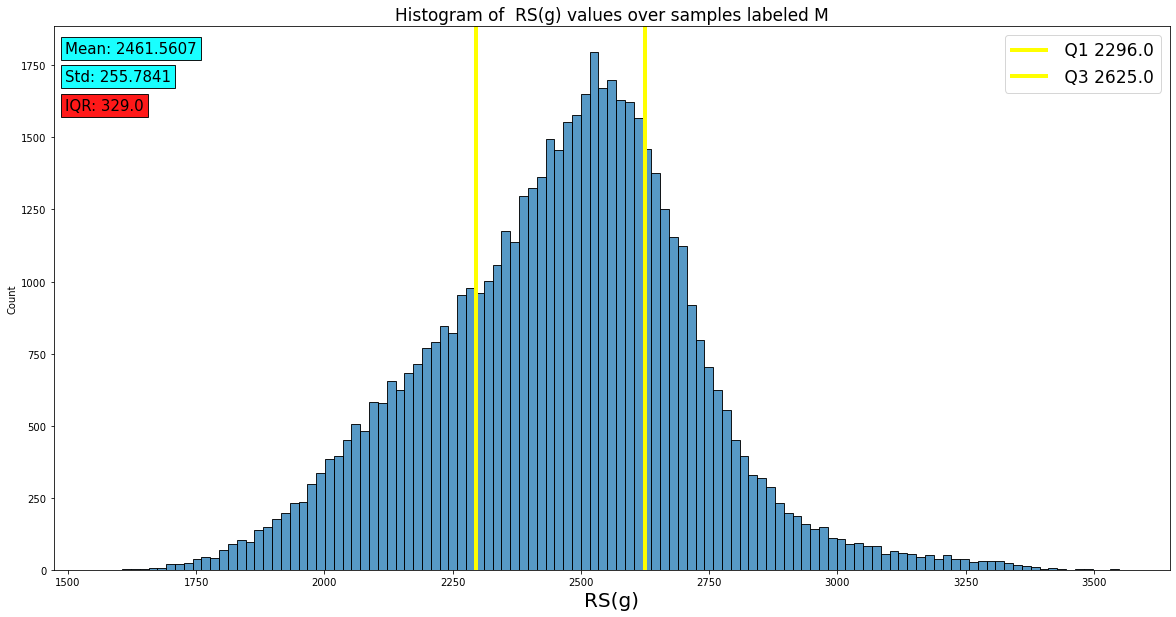

In [10]:
iqr = np.percentile(hst, 75)- np.percentile(hst, 25)
fig, axes = plt.subplots(1,1, figsize=(20,10))
hs=sns.histplot(hst,ax=axes)
axes.set_title("Histogram of  RS(g) values over samples labeled M",fontsize=17)
plt.axvline(np.percentile(hst, 25), color="yellow",  label=" Q1 {:0.1f}".format(np.percentile(hst, 25)),linewidth=4)
plt.axvline(np.percentile(hst, 75), color="yellow",  label=" Q3 {:0.1f}".format(np.percentile(hst, 75)),linewidth=4)
axes.set_xlabel("RS(g)",fontsize=20)
x_min,x_max=hs.get_xlim()
y_min,y_max=hs.get_ylim()
axes.text(x_min*1.015, y_max-y_max/6.5,f'IQR: {np.round(iqr,4)}' ,color='black',size=15, bbox=dict(facecolor='red', alpha=0.9))
axes.text(x_min*1.015, y_max-y_max/10,f'Std: {np.round(hst.std(),4)}' ,color='black',size=15, bbox=dict(facecolor='cyan', alpha=0.9))
axes.text(x_min*1.015, y_max-y_max/20,f'Mean: {np.round(hst.mean(),4)}' ,color='black',size=15, bbox=dict(facecolor='cyan', alpha=0.9))
plt.legend(loc = "upper right",fontsize=17)

### c. <u>Differential Expression </u>

#### The purpose is to determine the statistical significance of differential expression (DE) observed for each gene in H vs M. Evaluate the DE in both one-sided directions for every gene, using both Student t-test and WRS test. Report the number of genes overexpressed in M vs H at a p-value better (≤) than 0.07 and separately genes underexpressed in M vs H at a p-value of 0.07. For both directions use both a Student t-test and a WRS test

In [11]:
alpha = 0.07
t_overexpressed = [];t_underexpressed = [];wrs_overexpressed = [];wrs_underexpressed = []

In [12]:
t_overexpressed,t_underexpressed,wrs_overexpressed,wrs_underexpressed

([], [], [], [])

In [13]:
for i in tqdm(range(df.shape[0])):
    row = dfc.iloc[i].reset_index().copy()
    gene_name = row.reset_index().iloc[0,3]
    row = row.drop([0]).reset_index(drop=True)
    row.columns = ["Genes","Class",gene_name]
    m = row[row.Class =="M"].iloc[:,2]
    h = row[row.Class =="H"].iloc[:,2]
    t,pvalt = stats.ttest_ind(m,h); pvalt/=2
    wrs_t,pvalw = stats.ranksums(m,h) ; pvalw/=2
    if wrs_t> 0 and pvalw <=alpha:
        wrs_overexpressed.append((gene_name,wrs_t,pvalw))
    elif wrs_t<= 0 and pvalw <=alpha:
        wrs_underexpressed.append((gene_name,wrs_t,pvalw))
    if t> 0 and pvalt <=alpha:
        t_overexpressed.append((gene_name,t,pvalt))
    elif t<= 0 and pvalt <=alpha:
        t_underexpressed.append((gene_name,t,pvalt))

In [14]:
print("Student's t-test Evaluation: \n Underexpressed Genes : {0}\n Overexpressed Genes : {1}".format(len(t_overexpressed),len(t_underexpressed)))
print("\nWilcoxon rank-sum Evaluation: \n Underexpressed Genes : {0}\n Overexpressed Genes : {1}".format(len(wrs_overexpressed),len(wrs_underexpressed)))

Student's t-test Evaluation: 
 Underexpressed Genes : 8517
 Overexpressed Genes : 8639

Wilcoxon rank-sum Evaluation: 
 Underexpressed Genes : 10787
 Overexpressed Genes : 10667


### d. <u>Correlations</u>

#### Select the 80 most significant genes from each one of the one-sided WRS DE lists you computed in 3c. Generate a set of 160 genes, D, which is the union of the above two sets

In [51]:
s_wrs_over = sorted(wrs_overexpressed, key=lambda x: x[2])[:80]
s_wrs_under= sorted(wrs_underexpressed, key=lambda x: x[2])[:80]
D = pd.DataFrame(s_wrs_under+s_wrs_over,columns = ["Gene","statistic","p_value"])
D

,Gene,statistic,p_value
0,226423_at,-6.151719,3.832391e-10
1,234095_at,-5.899771,1.820032e-09
2,206978_at,-5.864778,2.248666e-09
3,243458_at,-5.766799,4.039573e-09
4,218805_at,-5.731806,4.968344e-09
...,...,...,...
155,228648_at,6.179713,3.210918e-10
156,243395_at,6.172714,3.356376e-10
157,211628_x_at,6.158717,3.666831e-10
158,203936_s_at,6.151719,3.832391e-10


#### 1) Compute Kendall 𝜏 correlations  in  all  pairs  within  D  (160 choose 2 numbers). Represent the correlation matrix as a 160x160 heatmap.

We'll assign the correlation matrix in a way such that the genes are already sorted by M and H, and now we will sort them by underexpression and overexpression, as in D matrix. this way we might get intresting insights from the arranged data

In [52]:
spec_genes = np.array(D.iloc[:,0])
corr_mat = dfc.iloc[np.where(df["ID_REF"].isin(spec_genes))[0],:]
corr_mat.columns = range(corr_mat.shape[1])
corr_mat = corr_mat.T
corr_mat.columns = corr_mat.iloc[0,:].copy()
corr_mat = corr_mat.drop([0]).reset_index(drop=True).astype('float');
corr_mat = corr_mat[list(D.Gene)]

In [53]:
D_mat = corr_mat.corr(method='kendall')

Text(104.09375, 0.5, 'Gene')

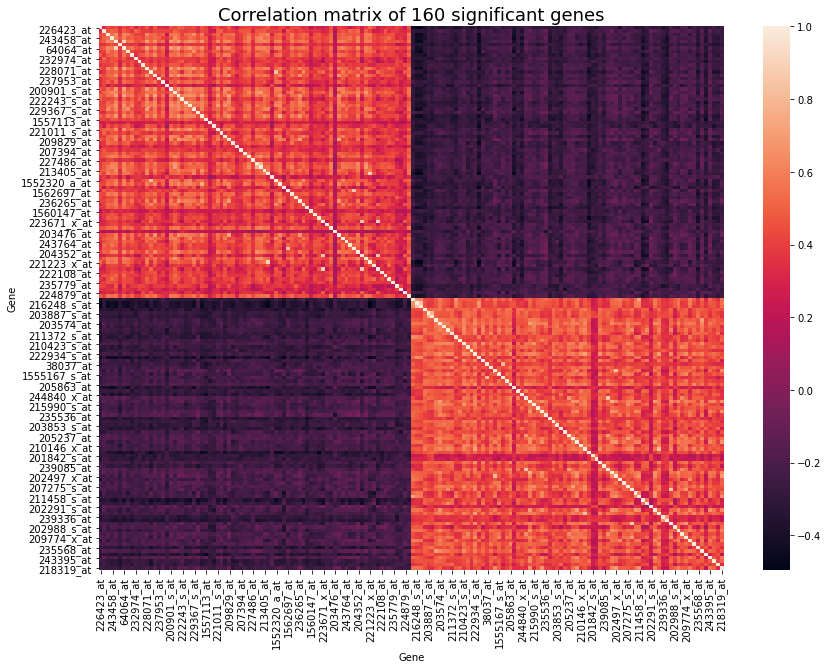

In [54]:
plt.figure(figsize = (14,10))
sns.heatmap(D_mat)
plt.title("Correlation matrix of 160 significant genes",fontsize = 18)
plt.xlabel("Gene")
plt.ylabel("Gene")

###  There is a big conclusion that arises from the heatmap above. the correlation matrix is symmetric! hence the corollary from the data is that overexpressed genes correlate together, and underexpressed genes correlate together. or as defined co-expressed.

**So, if the case above holds perfectly, we are expecting to see the follows:**
* we have two sets of 80 genes which one set is underexpressed and the other overexpressed. if we correlate under with under pairs and over with over pairs, we are expected to get a result of $${80 \choose 2} + {80 \choose 2} = 6320 \ co-expressed \ pairs$$
* but if we expect to get 6320 co - expressed genes, tha how many of them are not co -expressed? well in a perfect data where there are only co expression between under-under and over-over pairs, the number of not co expressed is:
$${160 \choose 2} - 2\cdot {80 \choose 2} = 6400 \ NOT \ co-expressed \ pairs$$

But lets look on following data separation:

In [66]:
m1 = D_mat < 1
m2 =  D_mat >0
print("There are {0} paired genes whom tau is bigger than 0".format(D_mat[m1 & m2].count().sum()))
print("There are {0} paired genes whom tau is smaller than 0".format(D_mat[D_mat < 0].count().sum()))
print("There are {0} paired same genes whom tau is 1".format(D_mat[D_mat == 1].count().sum()))
print("In total: {0} correlations".format(D_mat[D_mat == 1].count().sum()+D_mat[D_mat < 0].count().sum()+D_mat[m1 & m2].count().sum()))

There are 12640 paired genes whom tau is bigger than 0
There are 12800 paired genes whom tau is smaller than 0
There are 160 paired same genes whom tau is 1
In total: 25600 correlations


The data shows that we have 12640 pairs co-expressed, and 12800 pairs with negative correlation. its not even near to 6320 co expressed paired genes, that we expected to get. where lies the difference?

So, while examining the correlation matrix, we can safely say that each gene correlates with the rest. but does each gene correlation with the rest of the genes is unique in the correlation matrix?
the answere is NO!

suppose gene "X" correlate with the rest of the genes, and particualray with gene "Y". so the correlation matrix show $\tau (X,Y)$ and $\tau (Y,X)$, **BUT** $\tau (X,Y)=\tau (Y,X)$ thus we get double counting for each paired genes correlation.

Thus, there are 12640 paired genes whom tau is bigger than 0  in the correlation matrix but only  $\frac{12640}{2} = 6320$ co-expressed expected genes. in the same way we say for the not co - expressed genes: $\frac{12800}{2} = 6400$
so in general we say:
$$ 6320_{co-expr}\cdot 2  +  6400_{NOTco-expr}\cdot 2 + 160_{same-genes}= 25,600 \ correlations$$
the expectations met with the data entries.

now in the next sections we will see if the data is truly arranged as we thought it would be

#### 2) Under   a   NULL   model   that   assumes   that   genes   are   pairwise independent, what is the expected value for 𝜏? What is the observed mean of the numbers you calculated in the above section?

Under the NULL model that assumes that genes are pairwise independent, we assume to get $\tau = 0$

In [19]:
D_mat.mean().mean()


0.09016181231892698

As shown above, $\tau = D_{mean} = 0.09$

#### 3) What can you report about co-expression of genes in D (co-expression is inferred from the correlation of the expression levels of genes, across a set of samples)? Do we observe any significant co-expression? Explain your answer.

For the most significant expressions lets define a threshold $\tau > tau^+$ and $\tau < \tau^-$ where: $$\tau^+ = 0.75$$ $$\tau^- = -0.46$$
We chose those thresholds  in a "trial and error" method. they produced the same length (34) of paired genes which is pretty short length but enough in our opinion to show major significant trends.


In [20]:
tau_p = 0.75
tau_n = -0.46

In [21]:
m1 = D_mat < 1
m2 =  D_mat >tau_p
m3 = D_mat < tau_n
signfi = D_mat[m3 | (m1 & m2)]
trii = signfi.where(pd.notnull(signfi), -999)
lst_neg = []
lst_pos = []
for i in range(trii.shape[0]):
    for j in range(trii.shape[0]):
        if (trii.iloc[i,j] > -999) and (trii.iloc[i,j] < 0):
            expr1 = "Under" if D[D.Gene == trii.index[i]].values[0,1] < 0 else "Over"
            expr2 = "Under" if D[D.Gene == trii.columns[j]].values[0,1] < 0 else "Over"
            lst_neg.append((trii.index[i],expr1,trii.columns[j],expr2,trii.iloc[i,j]))
        elif trii.iloc[i,j] > 0:
            expr1 = "Under" if D[D.Gene == trii.index[i]].values[0,1] < 0 else "Over"
            expr2 = "Under" if D[D.Gene == trii.columns[j]].values[0,1] < 0 else "Over"
            lst_pos.append((trii.index[i],expr1,trii.columns[j],expr2,trii.iloc[i,j]))
print(" Number of paired Genes with tau > {0} : {1} ".format(tau_p,len(lst_pos)))
print(" Number of paired Genes with tau < {0} : {1} ".format(tau_n,len(lst_neg)))
tau_p_df = pd.DataFrame(lst_pos).sort_values(by = 1)
tau_p_df.columns = ["Gene1","Over/under","Gene2","Over/under","Tau"]
tau_n_df = pd.DataFrame(lst_neg).sort_values(by = 1)
tau_n_df.columns = ["Gene1","Over/under","Gene2","Over/under","Tau"]


 Number of paired Genes with tau > 0.75 : 34 
 Number of paired Genes with tau < -0.46 : 34 


#### For the paired genes with $\tau > tau^+$ we can state that both of genes which highly positive correlate, are both overexpressed or underexpressed genes, thus we refer to them as co - expressed.
see the table below

In [22]:
tau_p_df

,Gene1,Over/under,Gene2,Over/under,Tau
33,39402_at,Over,205067_at,Over,0.886621
18,216248_s_at,Over,204622_x_at,Over,0.851165
19,204622_x_at,Over,216248_s_at,Over,0.851165
20,203887_s_at,Over,203888_at,Over,0.783137
21,203888_at,Over,203887_s_at,Over,0.783137
22,38037_at,Over,203821_at,Over,0.800866
23,216236_s_at,Over,202497_x_at,Over,0.813647
24,203821_at,Over,38037_at,Over,0.800866
26,201531_at,Over,201473_at,Over,0.764045
27,211924_s_at,Over,210845_s_at,Over,0.838796


#### For the paired genes with $\tau < tau^-$ we can state that one gene is over expressed while the other is under expressed. and this results is what has been expected, and was discussed in recitation
see the table below

In [23]:
tau_n_df

,Gene1,Over/under,Gene2,Over/under,Tau
33,228648_at,Over,1557113_at,Under,-0.464440
18,216248_s_at,Over,223377_x_at,Under,-0.486291
19,216248_s_at,Over,221223_x_at,Under,-0.494125
20,204622_x_at,Over,226423_at,Under,-0.489177
21,204622_x_at,Over,218805_at,Under,-0.462791
22,204622_x_at,Over,206991_s_at,Under,-0.462474
23,204622_x_at,Over,223377_x_at,Under,-0.479283
17,216248_s_at,Over,226423_at,Under,-0.495362
24,204622_x_at,Over,221223_x_at,Under,-0.492063
26,204621_s_at,Over,233852_at,Under,-0.460571


### in our next answer we show exactly how many co-expressed pairs we get, whereas we already answered how many we would expect to get. 
because FDR of 0.05 gives us the fully matrix D, so no point in answering twice.

#### 4) How many co-expressed pairs do we observe in FDR=0.05?

Lets first sort D by its p_values in ascending order.

In [24]:
D_sort = D.sort_values(by=['p_value']).copy()
D_sort

,Gene,statistic,p_value
80,208869_s_at,7.691398,7.276809e-15
81,216248_s_at,7.663404,9.053458e-15
82,204622_x_at,7.348469,1.002448e-13
83,244054_at,7.229494,2.423984e-13
85,203888_at,7.215497,2.686869e-13
...,...,...,...
75,235779_at,-5.007457,2.757695e-07
76,242874_at,-5.003958,2.808256e-07
77,1565882_at,-4.996959,2.912071e-07
78,224879_at,-4.989961,3.019582e-07


Now lets apply FDR correction on the p_values:

In [25]:
D_sort.index = D_sort.reset_index().index+1
D_sort["FDR"] = D_sort["p_value"] *160/D_sort.index
D_sort

,Gene,statistic,p_value,FDR
1,208869_s_at,7.691398,7.276809e-15,1.164289e-12
2,216248_s_at,7.663404,9.053458e-15,7.242766e-13
3,204622_x_at,7.348469,1.002448e-13,5.346390e-12
4,244054_at,7.229494,2.423984e-13,9.695938e-12
5,203888_at,7.215497,2.686869e-13,8.597980e-12
...,...,...,...,...
156,235779_at,-5.007457,2.757695e-07,2.828405e-07
157,242874_at,-5.003958,2.808256e-07,2.861916e-07
158,1565882_at,-4.996959,2.912071e-07,2.948933e-07
159,224879_at,-4.989961,3.019582e-07,3.038573e-07


Looking at the FDR column we expect that all of the 160 most significant genes, will answer $FDR \leq 0.05$ thus remain significant

In [26]:
D_sort[D_sort["FDR"] <= 0.05].FDR.count()

160

##### So for D which contains the 160 most significant genes, all the pairs remains significant. now lets see how many co- expressed genes we have - meaning how many pairs positivly correlate

Now lets recheck the correlation matrix again and try to filter those co-expressed genes

In [27]:
D_mat

,226423_at,234095_at,206978_at,243458_at,218805_at,220144_s_at,64064_at,206991_s_at,225886_at,232974_at,...,209774_x_at,232213_at,204351_at,235568_at,200648_s_at,228648_at,243395_at,211628_x_at,203936_s_at,218319_at
0,,,,,,,,,,,,,,,,,,,,,
226423_at,1.000000,0.322614,0.437229,0.397650,0.454958,0.342816,0.440528,0.384948,0.464853,0.302000,...,-0.180375,-0.340754,-0.214595,-0.292105,-0.268604,-0.306122,-0.277262,-0.236446,-0.326324,-0.238920
234095_at,0.322614,1.000000,0.459905,0.497835,0.485879,0.357246,0.482993,0.424536,0.358895,0.521748,...,-0.202226,-0.149041,-0.214183,-0.297464,-0.154401,-0.322202,-0.131725,-0.251701,-0.218718,-0.279736
206978_at,0.437229,0.459905,1.000000,0.539889,0.645022,0.415791,0.614925,0.581237,0.489177,0.398062,...,-0.181612,-0.299938,-0.166357,-0.327974,-0.198103,-0.299938,-0.221604,-0.297052,-0.283859,-0.276438
243458_at,0.397650,0.497835,0.539889,1.000000,0.612863,0.453721,0.601732,0.483918,0.504020,0.444238,...,-0.232736,-0.199340,-0.197691,-0.325500,-0.161822,-0.361781,-0.190270,-0.307772,-0.333333,-0.262420
218805_at,0.454958,0.485879,0.645022,0.612863,1.000000,0.400536,0.910534,0.554433,0.569573,0.464440,...,-0.172129,-0.245104,-0.168419,-0.305298,-0.193568,-0.371264,-0.170068,-0.302412,-0.303236,-0.233972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228648_at,-0.306122,-0.322202,-0.299938,-0.361781,-0.371264,-0.284684,-0.350237,-0.342062,-0.386931,-0.324675,...,0.365492,0.238920,0.380746,0.476397,0.353948,1.000000,0.264482,0.374562,0.450423,0.195630
243395_at,-0.277262,-0.131725,-0.221604,-0.190270,-0.170068,-0.322614,-0.154813,-0.229897,-0.162647,-0.169656,...,0.494949,0.570398,0.512678,0.311482,0.528757,0.264482,1.000000,0.474335,0.382808,0.571635
211628_x_at,-0.236446,-0.251701,-0.297052,-0.307772,-0.302412,-0.379097,-0.276438,-0.317732,-0.277675,-0.265718,...,0.550608,0.446300,0.445475,0.494949,0.496186,0.374562,0.474335,1.000000,0.421975,0.512678


Now we only want the positive correlated pair of genes (but not a gene which correlated with itself of course):

In [28]:
m1 = D_mat < 1
m2 =  D_mat > 0
signfi = D_mat[m1 & m2]
trii = signfi.where(pd.notnull(signfi), -999)
lst_pos = []
for i in range(trii.shape[0]):
    for j in range(trii.shape[0]):
        if (trii.iloc[i,j] > -999):
            expr1 = "Under" if D[D.Gene == trii.index[i]].values[0,1] < 0 else "Over"
            expr2 = "Under" if D[D.Gene == trii.columns[j]].values[0,1] < 0 else "Over"
            lst_pos.append((trii.index[i],expr1,trii.columns[j],expr2,trii.iloc[i,j]))
# print(" Number of paired Genes with tau > {0} : {1} ".format(tau_p,len(lst_pos)))
tau_p_df = pd.DataFrame(lst_pos)
tau_p_df.columns = ["Gene1","Over/under1","Gene2","Over/under2","Tau"]
# tau_p_df.Tau.unique().count
tau_p_df

,Gene1,Over/under1,Gene2,Over/under2,Tau
0,226423_at,Under,234095_at,Under,0.322614
1,226423_at,Under,206978_at,Under,0.437229
2,226423_at,Under,243458_at,Under,0.397650
3,226423_at,Under,218805_at,Under,0.454958
4,226423_at,Under,220144_s_at,Under,0.342816
...,...,...,...,...,...
12635,218319_at,Over,200648_s_at,Over,0.468975
12636,218319_at,Over,228648_at,Over,0.195630
12637,218319_at,Over,243395_at,Over,0.571635
12638,218319_at,Over,211628_x_at,Over,0.512678


In [29]:
ovr1 = tau_p_df["Over/under1"] == "Over"
undr1 = tau_p_df["Over/under1"] == "Under" 
ovr2 = tau_p_df["Over/under2"] == "Over"
undr2 = tau_p_df["Over/under2"] == "Under" 
print("We get {0} Co - expressed pairs which one is over - expressed and the second is under - expressed (or vice versa)".format(tau_p_df[(ovr1 & undr2) | (undr1 & ovr2)].shape[0]))
tau_p_df[(ovr1 & undr2) | (undr1 & ovr2)].shape[0]

We get 0 Co - expressed pairs which one is over - expressed and the second is under - expressed (or vice versa)


0

##### we notice we get only over expressed co expressions or under expressed co expressions pairs but not a mixture of under and over! now lets count them , because the table above shows duplicates. lets count unique gene tags so the number of co expressed pairs whom apply to FDR = 0.05 ARE:

In [30]:
subset = tau_p_df[["Gene1","Gene2"]]
tuples = [tuple(x) for x in subset.to_numpy()]

In [31]:
a = tuples
b = list(set([ tuple(sorted(t)) for t in a ]))
print("We get {0} co-expressed genes under FDR = 0.05".format(len(b)))

We get 6320 co-expressed genes under FDR = 0.05


which makes sense because we have 80 over expressed genes and 80 under expressed genes. and we found out that there are no mixed co expression of over and under, hence the number of co - expressed genes under the unchanged D correlation matrix is: $${80 \choose 2} + {80 \choose 2} = 6320$$

#### 5) What  would  have  been  advantages  and  disadvantages  of computing co-expression for all genes in the study rather than only for genes in D? 

<u>advantages</u>: 
* Not missing out the genes that are might not be the most significant but can still "tell a signifcant story"

<u>disadvantages</u>: 
* We have 54628 genes( with the NaN removal) in our dataset. thus we need to calculate correlation between ${54628\choose 2 } \approx 1.5\cdot 10^9$ pairs. that would take alot of time to calculate
* Another problem that might arise that we can find significant unreasonable correlations, nicolas cage style

#### 6) Perform  the  above  steps on  the  same  set  D,but  restrict attention only to samples labeled M. What do you see now?Can you explain this?

In [32]:
spec_genes = np.array(D.iloc[:,0]) #get D genes
corr_mat_m = dfc.iloc[np.where(df["ID_REF"].isin(spec_genes))[0],:].copy()
corr_mat_m.columns = corr_mat_m.columns.get_level_values(1)
corr_mat_m = corr_mat_m.drop(columns= ["H"]) # NOW RESTRICT ATTENTION ONLY TO SAMPLES LABELED M
corr_mat_m = corr_mat_m.T
corr_mat_m.columns = corr_mat_m.iloc[0,:].copy()
corr_mat_m = corr_mat_m.reset_index(drop=True)
corr_mat_m = corr_mat_m.drop([0]).reset_index(drop=True).astype('float');
corr_mat_m = corr_mat_m[list(D.Gene)]
D_mat = corr_mat_m.corr(method='kendall')

Text(104.09375, 0.5, 'Gene')

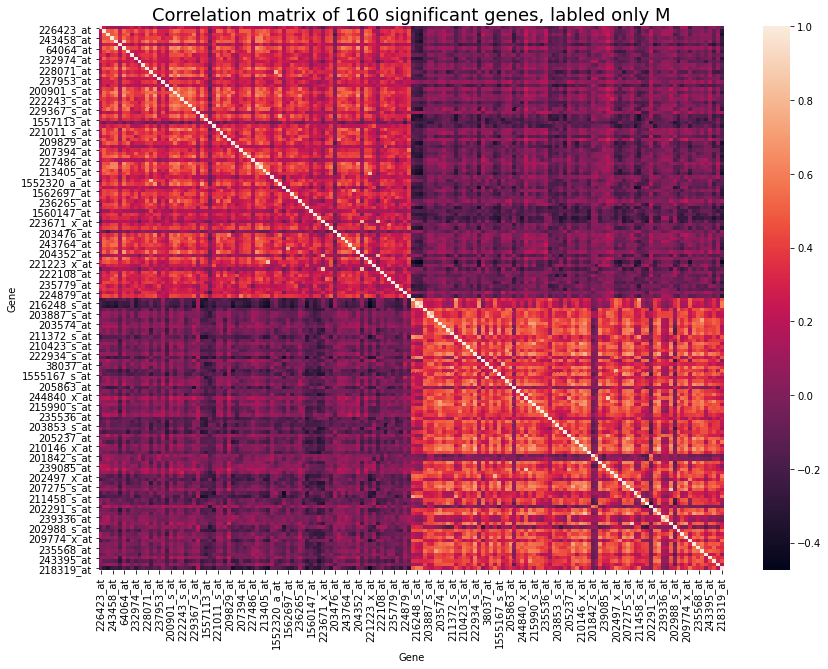

In [33]:
plt.figure(figsize = (14,10))
sns.heatmap(D_mat)
plt.title("Correlation matrix of 160 significant genes, labled only M",fontsize = 18)
plt.xlabel("Gene")
plt.ylabel("Gene")

We got roughly the same correlation heatmap, with similar structure, but now the correlations are weaker!
we recall that we are analyzing genes with high differential expressions in samples which are healty and with AMI.
removing the healthy samples results in correlating between AMI samples only thus the result will state less significant correlations compared to AMI with Healthy samples, hence -> less co-expressed genes

### e. <u>Plots and Conclusions of the DE and correlation analysis</u>

#### 1) Construct the DE overabundance plots (blue and green lines as  shown  in  class) for M  vs  H  over expression  (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c.

First lets get the p_values of all genes with wrs and ttest calculations, as stated in piazza. due to overexpression request, for any gene which is under expressed, we will return his 1 - p_value, in order to show the overexpression as requested. 

In [34]:
def fdr(p_vals):
    ranked_p_values = stats.rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

In [35]:
t_pval_one = []
wrs_pval_one = []
for i in tqdm(range(df.shape[0])):
    row = dfc.iloc[i].reset_index().copy()
    gene_name = row.reset_index().iloc[0,3]
    row = row.drop([0]).reset_index(drop=True)
    row.columns = ["Genes","Class",gene_name]
    m = row[row.Class =="M"].iloc[:,2]
    h = row[row.Class =="H"].iloc[:,2]
    t,pvalt = stats.ttest_ind(m,h); pvalt/=2
    if t<0:
        pvalt = 1 -pvalt
    wrs_t,pvalw = stats.ranksums(m,h) ; pvalw/=2
    if wrs_t<0:
        pvalw = 1 - pvalw
    wrs_pval_one.append((gene_name,wrs_t,pvalw))
    t_pval_one.append((gene_name,t,pvalt))

In [36]:
t_pval_one = pd.DataFrame(t_pval_one,columns = ["Gene","statistic","p_value"])
wrs_pval_one = pd.DataFrame(wrs_pval_one,columns = ["Gene","statistic","p_value"])

wrs_pval_s = wrs_pval_one.sort_values(by = ["p_value"])
t_pval_s = t_pval_one.sort_values(by = ["p_value"])
t_pval_s["Ranks"] = t_pval_s.p_value * t_pval_s.shape[0]
wrs_pval_s["Ranks"] = wrs_pval_s.p_value * wrs_pval_s.shape[0]
t_pval_s["Actual_Ranks"] = t_pval_s.p_value.rank(method='max')
wrs_pval_s["Actual_Ranks"] = wrs_pval_s.p_value.rank(method='max')
wrs_pval_s["FDR"] = fdr(wrs_pval_s.p_value)
t_pval_s["FDR"] = fdr(t_pval_s.p_value)

*Note: we will use $\epsilon = 0.0001$ for FDR = 0.05 & FDR = 0.01 and $\epsilon = 0.00001$ for FDR = 0.005 due to the numeric nature of the values. we assume that this value is decent to get really close values to the equality of the FDR value

The number of genes at which we observe FDR =0.05 with T-test is: 2105
The number of genes at which we observe FDR =0.01 with T-test is: 1306
The number of genes at which we observe FDR =0.005 with T-test is: 1104


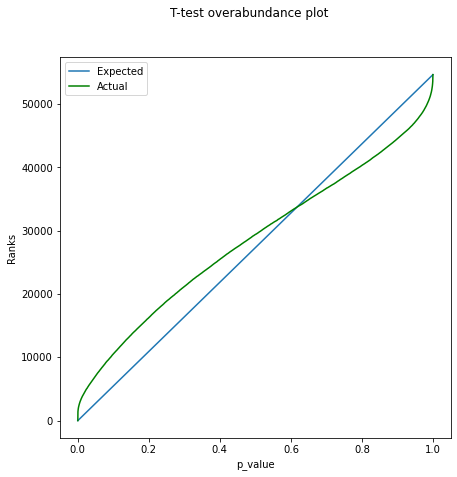

In [37]:
plt.figure(figsize = (7,7))
plt.suptitle('T-test overabundance plot')
sns.lineplot(data=t_pval_s, x="p_value", y="Ranks",label = "Expected")
sns.lineplot(data=t_pval_s, x="p_value", y="Actual_Ranks",color='green',label = "Actual")
plt.legend()
print("The number of genes at which we observe FDR =0.05 with T-test is: {0}".format(t_pval_s[t_pval_s.FDR <= 0.0501].count()[0]))
print("The number of genes at which we observe FDR =0.01 with T-test is: {0}".format(t_pval_s[t_pval_s.FDR <= 0.0101].count()[0]))
print("The number of genes at which we observe FDR =0.005 with T-test is: {0}".format(t_pval_s[t_pval_s.FDR <= 0.00501].count()[0]))

The number of genes at which we observe FDR =0.05 with WRS is: 2808
The number of genes at which we observe FDR =0.01 with WRS is: 1605
The number of genes at which we observe FDR =0.005 with WRS is: 1323


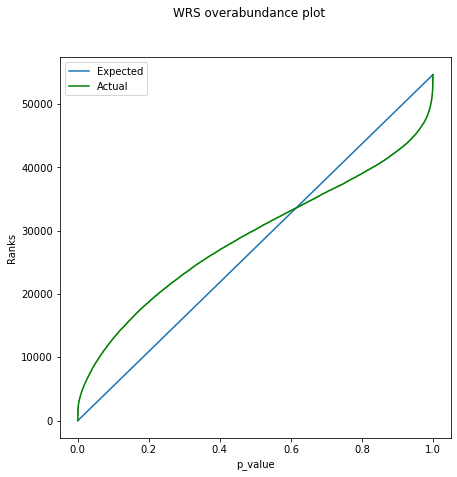

In [38]:
plt.figure(figsize = (7,7))
plt.suptitle('WRS overabundance plot')
sns.lineplot(data=wrs_pval_s, x="p_value", y="Ranks",label = "Expected")
sns.lineplot(data=wrs_pval_s, x="p_value", y="Actual_Ranks",color='green',label = "Actual")
plt.legend()
print("The number of genes at which we observe FDR =0.05 with WRS is: {0}".format(wrs_pval_s[wrs_pval_s.FDR <= 0.0501].count()[0]))
print("The number of genes at which we observe FDR =0.01 with WRS is: {0}".format(wrs_pval_s[wrs_pval_s.FDR <= 0.0101].count()[0]))
print("The number of genes at which we observe FDR =0.005 with WRS is: {0}".format(wrs_pval_s[wrs_pval_s.FDR <= 0.00501].count()[0]))

#### 2) Select any 3 differentially expressed genes, from D (which was defined in 3d), and produce a graphical representation of their expression patterns that demonstrates the observed DE

In [39]:
print("The selected genes are: {0}, {1}, {2}".format(D.iloc[:,0][0],D.iloc[:,0][80],D.iloc[:,0][120]))

The selected genes are: 226423_at, 208869_s_at, 205237_at


In [40]:
spec_genes = np.array([D.iloc[:,0][0],D.iloc[:,0][80],D.iloc[:,0][120]])
corr_mat_3 = dfc.iloc[np.where(df["ID_REF"].isin(spec_genes))[0],:]
corr_mat_3.columns = corr_mat_3.columns.get_level_values(1)
corr_mat_3_h = corr_mat_3.drop(columns= "M")
corr_mat_3_h = corr_mat_3_h.set_index('Class')
corr_mat_3_m = corr_mat_3.drop(columns= ["H"])
corr_mat_3_m = corr_mat_3_m.set_index('Class')

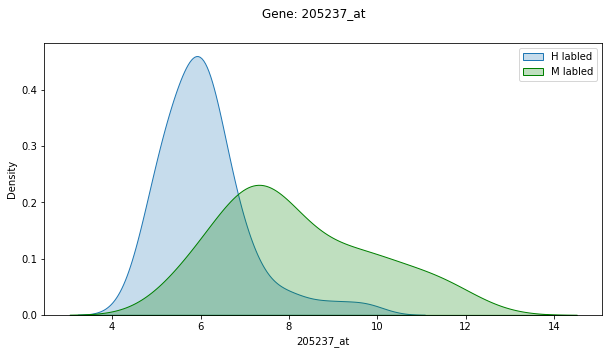

In [41]:
plt.figure(figsize = (10,5))
plt.suptitle('Gene: {0}'.format(corr_mat_3_h.iloc[0,:].name))
sns.distplot(corr_mat_3_h.iloc[0,:] ,kde_kws={"shade":True},hist=False,label = "H labled")
sns.distplot(corr_mat_3_m.iloc[0,:] ,color = "green",kde_kws={"shade":True},hist=False,label = "M labled")
plt.legend()

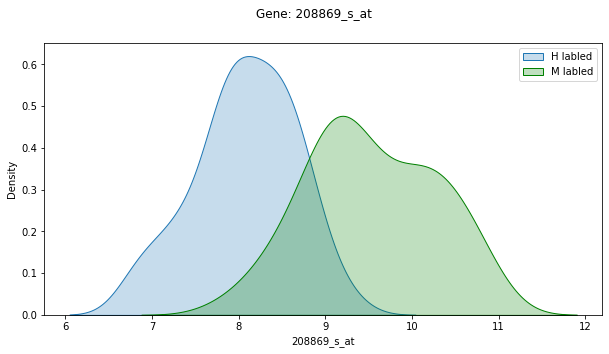

In [42]:
plt.figure(figsize = (10,5))
plt.suptitle('Gene: {0}'.format(corr_mat_3_h.iloc[1,:].name))
sns.distplot(corr_mat_3_h.iloc[1,:] ,kde_kws={"shade":True},hist=False,label = "H labled")
sns.distplot(corr_mat_3_m.iloc[1,:] ,color = "green",kde_kws={"shade":True},hist=False,label = "M labled")
plt.legend()

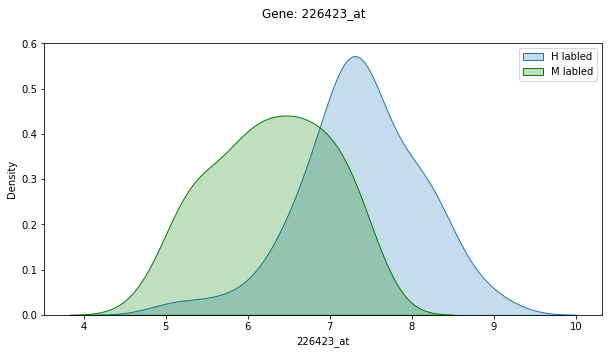

In [43]:
plt.figure(figsize = (10,5))
plt.suptitle('Gene: {0}'.format(corr_mat_3_h.iloc[2,:].name))
sns.distplot(corr_mat_3_h.iloc[2,:] ,kde_kws={"shade":True},hist=False,label = "H labled")
sns.distplot(corr_mat_3_m.iloc[2,:] ,color = "green",kde_kws={"shade":True},hist=False,label = "M labled")
plt.legend()
plt.show()

#### 3) Heatmap 
#### Draw a heatmap representation of the expression values of the genes in D (from 3d), across the entire cohort (all samples). Order the genes and the samples to produce the maximal visual effect.

In [44]:
spec_genes = np.array(D.iloc[:,0])
D_mat_cohort = dfc.iloc[np.where(df["ID_REF"].isin(spec_genes))[0],:]
D_mat_cohort  = D_mat_cohort .set_index(D_mat_cohort .iloc[:,0].name)
D_mat_cohort  = D_mat_cohort.loc[spec_genes]

Text(104.09375, 0.5, 'Gene')

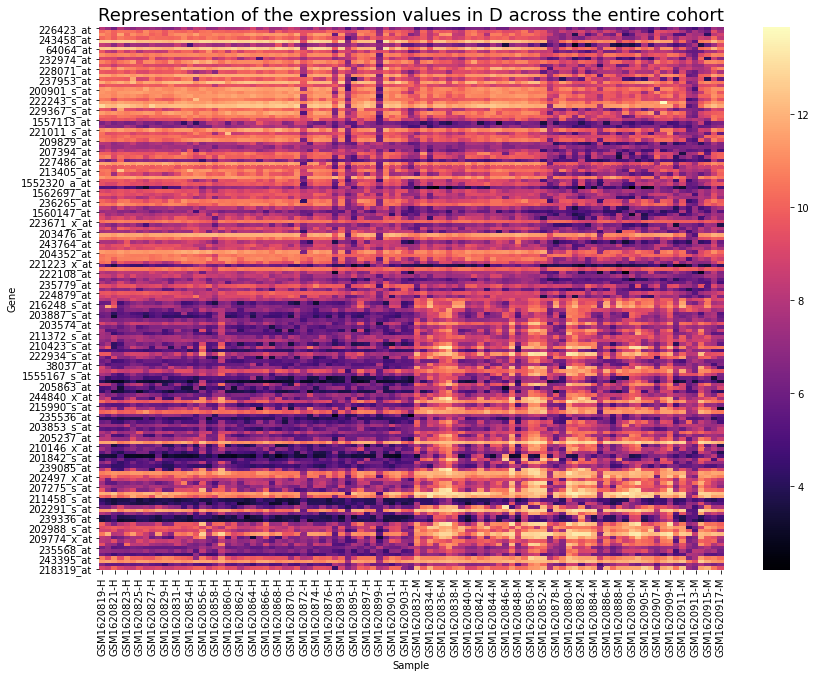

In [47]:
plt.figure(figsize = (14,10))
sns.heatmap(D_mat_cohort, cmap= "magma")
plt.title("Representation of the expression values in D across the entire cohort",fontsize = 18)
plt.xlabel("Sample")
plt.ylabel("Gene")